# Emojifier
**in this notebook the emojifier model will works as sentiment classifier**

**the steps will be:**

1 - Create an embedding layer in Keras with pre-trained word vectors

2 - Build and train a classifier using an LSTM & DropOut Technique

## 1 - DataPreprcess

In [14]:
import numpy as np
from emo_functions import *
import emoji
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform

%matplotlib inline

X contains 127 sentences (strings).

Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.

The dataset is split between training (127 examples) and testing (56 examples).

In [2]:
X_train, Y_train = read_csv('/content/train_emoji.csv')
X_test, Y_test = read_csv('/content/test_emoji.csv')

**This image shows the encoding of the emojies that are in the dataset**

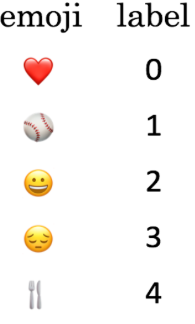

**and this is how the sentences (X) and labels (Y) are in the csv file**

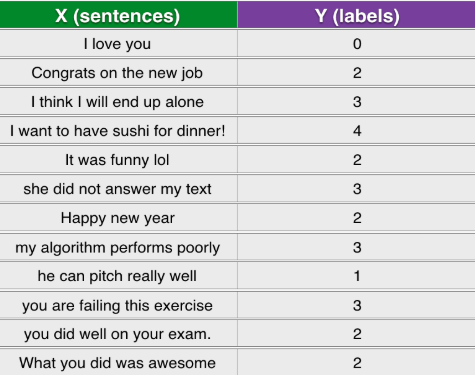

In [3]:
# This function will return the longest string based on number of words
# the shorter strings will be padded with zeros to ensure one size for all strings
maxLen = len(max(X_train, key=lambda x: len(x.split())).split())

In [4]:
# print some examples of the dataset with dictionary mapping the label to emoji
# to make it more user-friendly
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


**Here we are using a pretrained embedding with 50 dimensionsal vector for each word**

**Note:**

**to Download the pretrained embedding follow this link and download it**

https://www.kaggle.com/datasets/watts2/glove6b50dtxt/data

In [6]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/glove.6B.50d.txt')

In [9]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()'

    Arguments:
    X -- array of sentences (strings), of shape (m,)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this.

    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """

    m = X.shape[0]

    X_indices = np.zeros((m, max_len))

    for i in range(m):

        sentence_words = X[i].lower().split()

        j = 0

        # Loop over the words of sentence_words
        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
                j =  j + 1

    return X_indices

In [20]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
# one hot encoding to the labels so emoji like ❤️ (Heart) can be represented as
# [1. 0. 0. 0. 0.] in a vecotr with 0th index is only the 1
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [ ]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
# Doing the same for test dataset
Y_test_oh = convert_to_one_hot(Y_test, C = 5)

In [13]:
# this is an example of sentences_to_indices function that also padded the shorter sentences
X1 = np.array(["hello everyone", "what is your favorite movie", "I do not know what to type here"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=8)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['hello everyone' 'what is your favorite movie'
 'I do not know what to type here']
X1_indices =
 [[176468. 141948.      0.      0.      0.      0.      0.      0.]
 [386307. 192973. 394565. 145839. 251034.      0.      0.      0.]
 [185457. 126552. 264550. 209645. 386307. 360915. 368669. 177231.]]


## 2 - Build&Train the model

In [15]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.

    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """

    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = next(iter(word_to_vec_map.keys()))
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)

    emb_matrix = np.zeros((vocab_size, emb_dim))

    # Set each row "idx" of the embedding matrix to be
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Define Keras embedding layer without being trainable
    embedding_layer = Embedding(vocab_size, emb_dim, trainable = False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer.
    embedding_layer.build((None,))

    # Set the weights of the embedding layer to the embedding matrix. the layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

In [16]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


In [17]:
def Emojifier(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojifier model.

    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """


    sentence_indices = Input(shape=input_shape, dtype='int32')

    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)

    X = LSTM(128, return_sequences=True)(embeddings)

    X = Dropout(rate = 0.5)(X)

    X = LSTM(128, return_sequences=False)(X)

    X = Dropout(rate = 0.5)(X)

    X = Dense(5)(X)

    X = Activation('softmax')(X)

    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)

    return model

In [18]:
model = Emojifier((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 10, 50)         │    20,000,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 128)        │        91,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,223,927 (77.15 MB)

 Trainable params: 223,877 (874.52 KB)

 Non-trainable params: 20,000,050 (76.29 MB)

In [19]:
# compile the model with adam optimizer and CrossEntropy loss
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.2198 - loss: 1.6095
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3594 - loss: 1.5365
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4082 - loss: 1.4519
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4545 - loss: 1.3705
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4741 - loss: 1.3057
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5740 - loss: 1.1558
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6338 - loss: 1.0448
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6091 - loss: 0.9338
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7080 - loss: 0.8022
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7344 - loss: 0.7930
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7527 - loss: 0.7456
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8210 - loss: 0.5859
E

## 3 - Test&Evaluate the model

In [22]:
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8423 - loss: 0.5007 

Test accuracy =  0.8571428656578064


In [23]:
# These are some of the samples the model has predicted it with wrong emoji
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step
Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😞 prediction: work is horrible	😄
Expected emoji:🍴 prediction: any suggestions for dinner	😄
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😞 prediction: My life is so boring	😄
Expected emoji:😞 prediction: go away	⚾


**The model can know the context of a sentence even if the word "Happy" sneak into the sentence it can classify it correctly and you can try you own sentences to test the model**

In [24]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.
x_test = np.array(['not feeling happy'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
not feeling happy 😞
